# Data input line

Generating basic signals that will simulated expected signal types for the various astronomical observations, including diffuse, spectral and pulsar observations

Input:
* Coarse channelised voltage input, time averaged over dump rate

Output:
* Imaging and spectral will use visibility output (cross/auto correlation products, complex signal)
* Pulsar search, timing and (maybe?) transient search will use tied array beam data (going to assume for the moment channelised total power spectrum, real signal)

Terminology:
* Dump rate = data capture/correlator will accumulate a number of snap shot data chunks (e.g. 1s, 4s, 8s) and average that together to give the channelised voltage output products of a single scan
* Integration time = normally associated with the time required for the observation to achieve the sensitivity needed to clearly detect the object above the noise.

Notes:
* Need to check if the passband shaping will be performed in the station correlator and the channels assigned per beam (multi-beam spects) -- because currently I am assuming cross-correlation and fine channelisation in the CBF   
FXF or FBF architecture with the first F at station level (?)


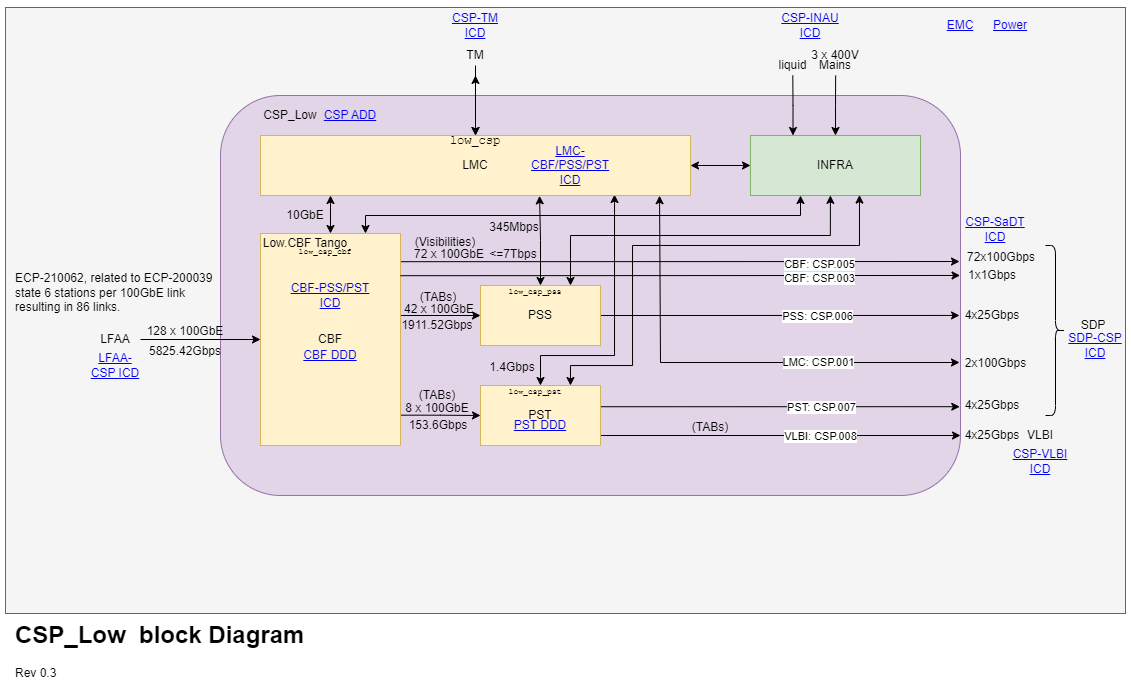

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Performance specifications
Add values and notes to requirements where values are specified here

In [ ]:
# bandwidth
bw=400  # MHz
print(f"Bandwidth bw={bw} MHz per polarisation")
# sample rate
fs = 800  # Msamp/s
print(f"Sample rate <requirement> fs={fs} Msamp/s")
# dump rate
ts = 1./fs  # s
print(f"ADC dump rate ts={ts} s")
# integration time
T = 5  # s
print(f"Integration/capture time T={T} s")
# number of time samples
N = int(T/ts)
print(f"Number samples captures N={N}")

Bandwidth bw=400 MHz per polarisation
Sample rate <requirement> fs=800 Msamp/s
ADC dump rate ts=0.00125 s
Integration/capture time T=5 s
Number samples captures N=4000


# Basic channelisation

Returns the Fourier transform and Fourier frequencies of input time signal

In [ ]:
def simFFT(signal, ts):
  FFTcomponents = np.fft.fftshift(np.fft.fft(np.fft.fftshift(signal)))
  N = len(signal)
  FFTfrequencies = np.fft.fftshift(np.fft.fftfreq(N, ts))
  return FFTcomponents, FFTfrequencies

# Generate test input signals

## Diffuse (continuum) emission
Imaging and spectral line visibility data, assuming an unresolved (compact) target. Because we should see a constant amplitude over time and zero phase slope. Amplitude will be arb dB values (calibrated on sky), but should be "relatively constant over time and frequency", given an anticipated bandpass ripple (need to find out how much dB ripple).
Phase slope means a time offset between the station beams (the stations are not synced), but this should be taken care of within the CBF.

Diffuse (continuum) emission is equally distributed over all frequencies in the band and can be simulated as Gaussian white noise centered around an amplitude since the emission is distributed over the frequency range. Noise levels are set using the standard deviation around the mean.

Caution: Noise out of a correlator becomes contaminated by the electronic noise which is generally pink or red noise. So over time the white noise average will be affected and deviate from the simulated input signal results. This is calculated by the Alan variance, it is not our problem, it just means we have to take into account the sigal dump rate and averaging time when we plug in the correlator system.

This should show the shape of the passband at some arb log amplitude
Over <? spec> seconds, stability in passband for CBF


In [ ]:
def constant(N, amplitude=1.0):
  return amplitude * np.ones(N)

In [ ]:
def diffuse_radiation(len, mean=0.0, std=0.5):
  return np.random.normal(mean, std, size=len)

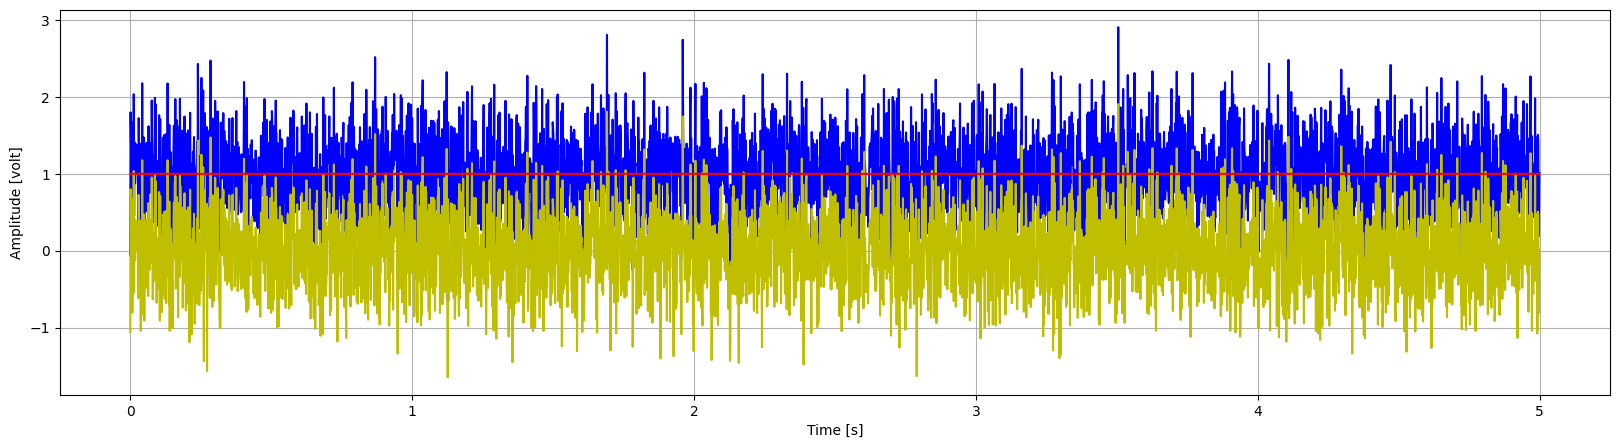

In [ ]:
const = constant(N, amplitude=1.0)
# noise = diffuse_radiation(N, mean=1.0, std=0.5)
noise = diffuse_radiation(N, mean=0.0, std=0.5)

signal = noise + const

time = np.array(range(0, N)) * ts

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(time, signal, 'b')
ax.plot(time, noise, 'y', time, const, 'r')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude [volt]")
ax.grid(True)
plt.show()

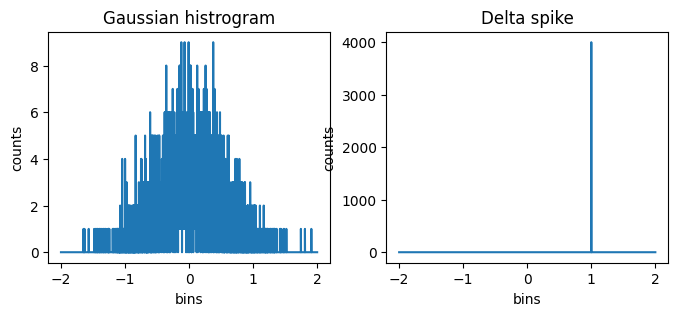

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
hist, bin_edges = np.histogram(noise, range=(-(int(noise.max())+1), int(noise.max())+1), bins=N + 1)
ax[0].plot(bin_edges[:-1], hist)
ax[0].set_xlabel("bins")
ax[0].set_ylabel("counts")
ax[0].set_title("Gaussian histrogram")  # power distributed around mean over standard deviation
hist, bin_edges = np.histogram(const, range=(-(int(const.max())+1), int(const.max())+1), bins=N + 1)
ax[1].plot(bin_edges[:-1], hist)
ax[1].set_xlabel("bins")
ax[1].set_ylabel("counts")
ax[1].set_title("Delta spike")  # all the power in one bin (amplitude)
plt.show()

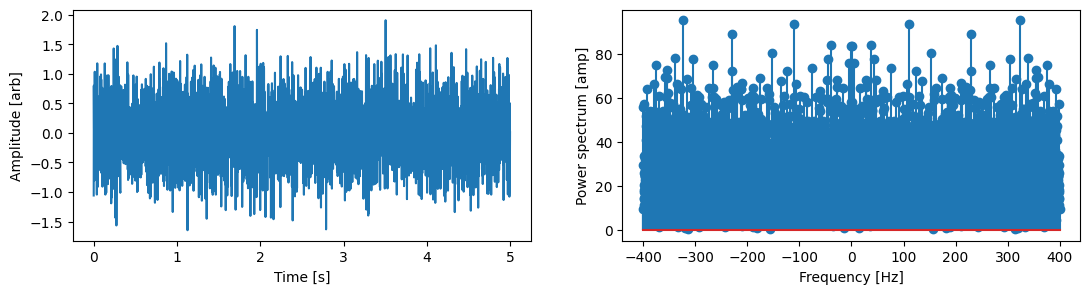

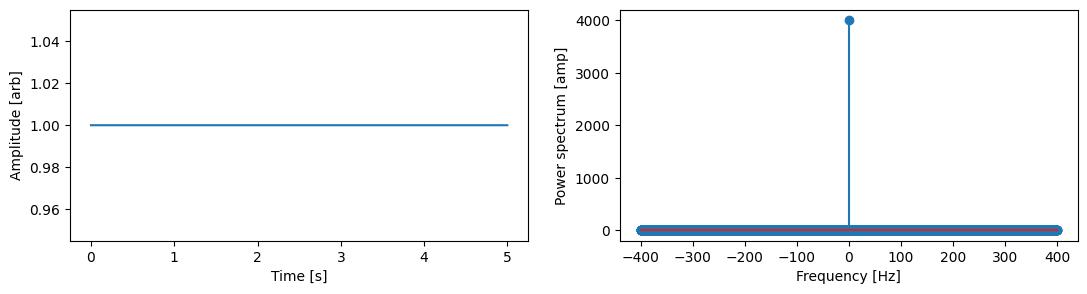

In [ ]:
fftsignal, freqs = simFFT(noise, ts)
fig, ax1 = plt.subplots(1,2,figsize=[13,3])
ax1[0].plot(time, noise)
ax1[0].set_xlabel('Time [s]')
ax1[0].set_ylabel('Amplitude [arb]')
ax1[1].stem(freqs, abs(fftsignal))
ax1[1].set_xlabel('Frequency [Hz]')
ax1[1].set_ylabel('Power spectrum [amp]')

fftsignal, freqs = simFFT(const, ts)
fig, ax1 = plt.subplots(1,2,figsize=[13,3])
ax1[0].plot(time, const)
ax1[0].set_xlabel('Time [s]')
ax1[0].set_ylabel('Amplitude [arb]')
ax1[1].stem(freqs, abs(fftsignal))
ax1[1].set_xlabel('Frequency [Hz]')
ax1[1].set_ylabel('Power spectrum [amp]')  # CD spike because const signal = mean added as bias (removed by subtracting average)
plt.show()

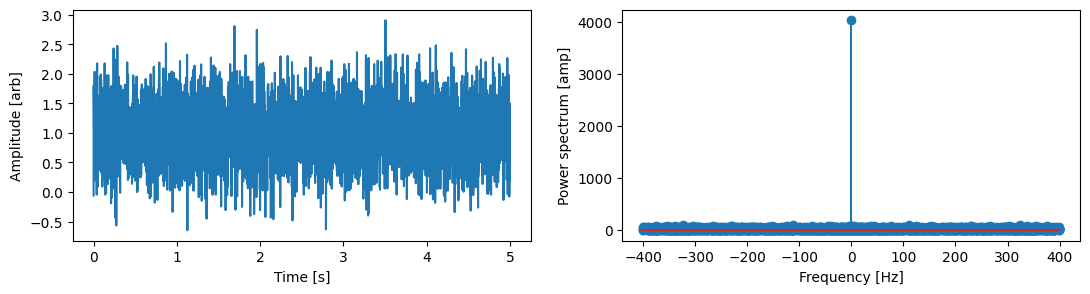

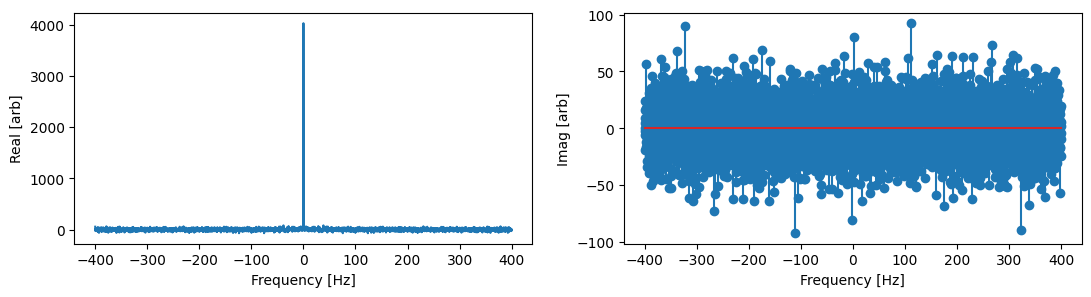

In [ ]:
fftsignal, freqs = simFFT(signal, ts)
fig, ax1 = plt.subplots(1,2,figsize=[13,3])
ax1[0].plot(time, signal)
ax1[0].set_xlabel('Time [s]')
ax1[0].set_ylabel('Amplitude [arb]')
ax1[1].stem(freqs, abs(fftsignal))
ax1[1].set_xlabel('Frequency [Hz]')
ax1[1].set_ylabel('Power spectrum [amp]')

fig, ax2 = plt.subplots(1,2,figsize=[13,3])
ax2[0].plot(freqs, fftsignal.real)
ax2[0].set_xlabel('Frequency [Hz]')
ax2[0].set_ylabel('Real [arb]')
ax2[1].stem(freqs, fftsignal.imag)
ax2[1].set_xlabel('Frequency [Hz]')
ax2[1].set_ylabel('Imag [arb]')

plt.show()

## Beam shape


Drift scan over a point source object shows the telescope beam shape. Width (FWHM of synthesized beam) will depend on longest baseline or station diameter for single station beam

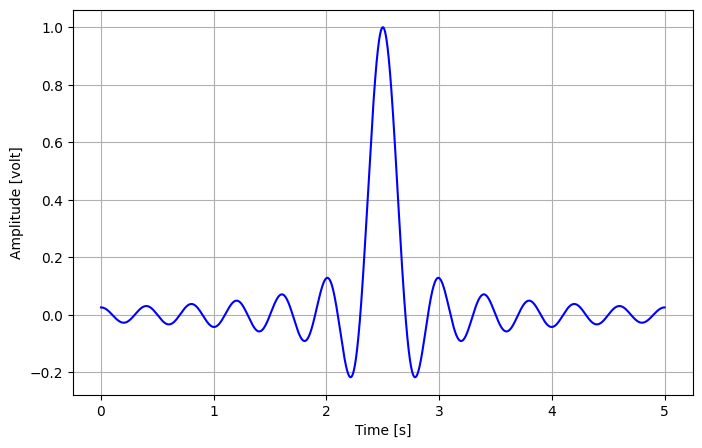

In [ ]:
def sincfunc(t, scale):
  return np.sinc(t/scale)

shift_time = time-time[int(N/2)]
y = sincfunc(5.*shift_time, 1.)
# y = sincfunc(50.*shift_time, 1.)
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(time, y, 'b')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude [volt]")
ax.grid(True)
plt.show()

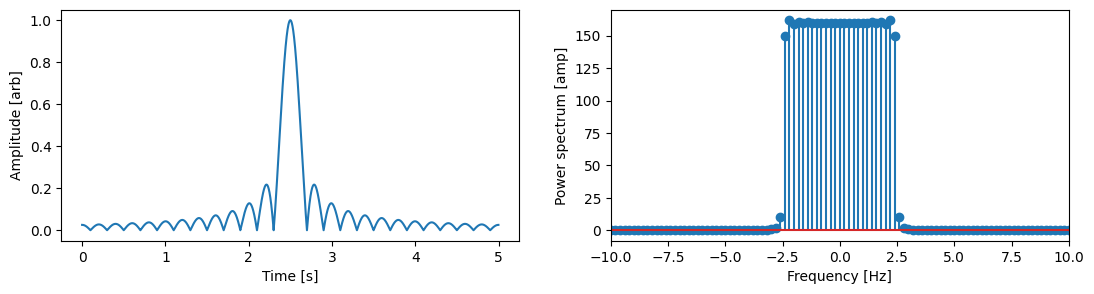

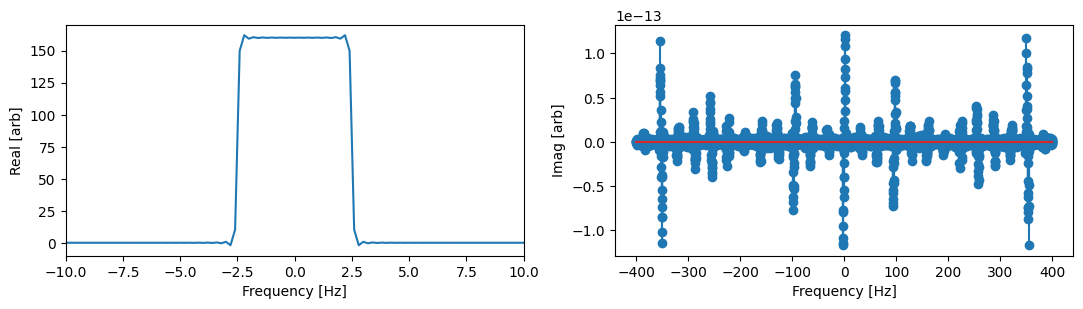

In [ ]:
fftsignal, freqs = simFFT(y, ts)
fig, ax1 = plt.subplots(1,2,figsize=[13,3])
ax1[0].plot(time, np.abs(y))
ax1[0].set_xlabel('Time [s]')
ax1[0].set_ylabel('Amplitude [arb]')
ax1[1].stem(freqs, abs(fftsignal))
ax1[1].set_xlim(-10, 10)
ax1[1].set_xlabel('Frequency [Hz]')
ax1[1].set_ylabel('Power spectrum [amp]')

fig, ax2 = plt.subplots(1,2,figsize=[13,3])
ax2[0].plot(freqs, fftsignal.real)
ax2[0].set_xlabel('Frequency [Hz]')
ax2[0].set_ylabel('Real [arb]')
ax2[0].set_xlim(-10, 10)
ax2[1].stem(freqs, fftsignal.imag)
ax2[1].set_xlabel('Frequency [Hz]')
ax2[1].set_ylabel('Imag [arb]')

plt.show()

## Spectral line emission

Spectral line emission is located in a narrow number of channels. Simulated by adding a cosine signal with specific frequency to the noise signal and checking that the frequency is in the correct channel at some arg log amplitude

Sweeping a clean cosine over the passband shows channel shape and setting frequency shows channelisation accuracy
Increasing amplitude evaluate dynamic range (SNR)

In [ ]:
def spectralline(time, fs, amplitude=1.):
  return amplitude*np.cos(2.*np.pi*time/fs)

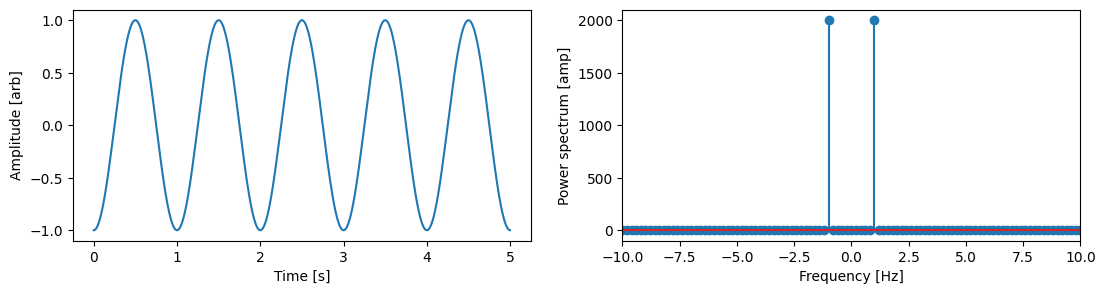

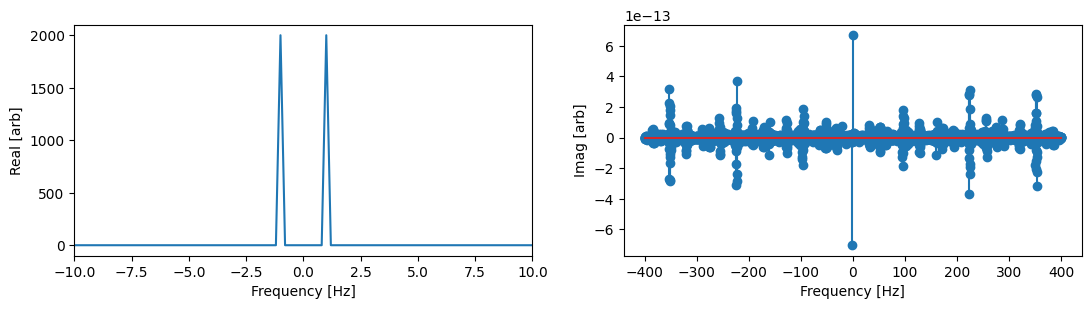

In [ ]:
y = spectralline(shift_time, 1)
fftsignal, freqs = simFFT(y, ts)
fig, ax1 = plt.subplots(1,2,figsize=[13,3])
ax1[0].plot(time, y)
ax1[0].set_xlabel('Time [s]')
ax1[0].set_ylabel('Amplitude [arb]')
ax1[1].stem(freqs, abs(fftsignal))
ax1[1].set_xlabel('Frequency [Hz]')
ax1[1].set_ylabel('Power spectrum [amp]')
ax1[1].set_xlim(-10, 10)

fig, ax2 = plt.subplots(1,2,figsize=[13,3])
ax2[0].plot(freqs, fftsignal.real)
ax2[0].set_xlabel('Frequency [Hz]')
ax2[0].set_ylabel('Real [arb]')
ax2[0].set_xlim(-10, 10)
ax2[1].stem(freqs, fftsignal.imag)
ax2[1].set_xlabel('Frequency [Hz]')
ax2[1].set_ylabel('Imag [arb]')

plt.show()

## Pulsar

Pulsars are beamed emission from a rotation stellar object such as a neutron star. Simulated by either creating a Gaussian/Sync profile or pulse provide over time and addting that to the noise.

In [ ]:
def gaussian(t, sigma):
  return (1./(np.sqrt(2.*np.pi)*sigma))*np.exp(-t**2.0/(2.0*sigma**2.0))

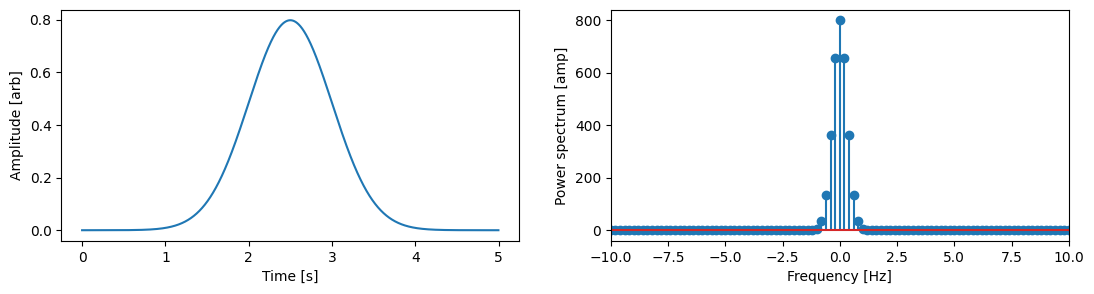

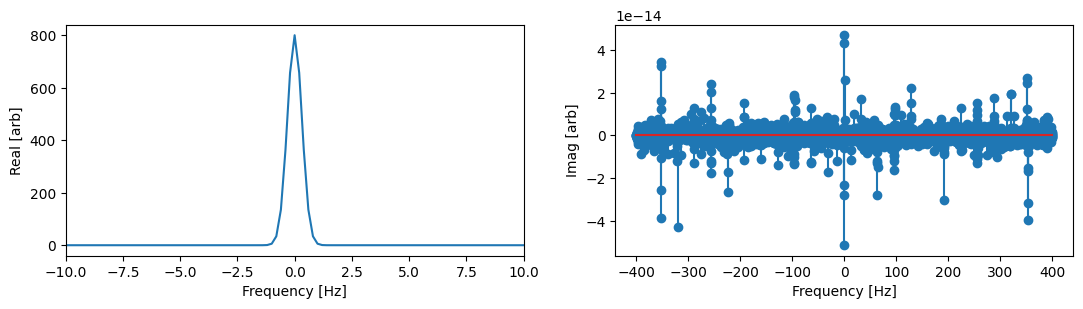

In [ ]:
y = gaussian(shift_time, 0.5)
fftsignal, freqs = simFFT(y, ts)
fig, ax1 = plt.subplots(1,2,figsize=[13,3])
ax1[0].plot(time, y)
ax1[0].set_xlabel('Time [s]')
ax1[0].set_ylabel('Amplitude [arb]')
ax1[1].stem(freqs, abs(fftsignal))
ax1[1].set_xlabel('Frequency [Hz]')
ax1[1].set_ylabel('Power spectrum [amp]')
ax1[1].set_xlim(-10, 10)

fig, ax2 = plt.subplots(1,2,figsize=[13,3])
ax2[0].plot(freqs, fftsignal.real)
ax2[0].set_xlabel('Frequency [Hz]')
ax2[0].set_ylabel('Real [arb]')
ax2[0].set_xlim(-10, 10)
ax2[1].stem(freqs, fftsignal.imag)
ax2[1].set_xlabel('Frequency [Hz]')
ax2[1].set_ylabel('Imag [arb]')

plt.show()

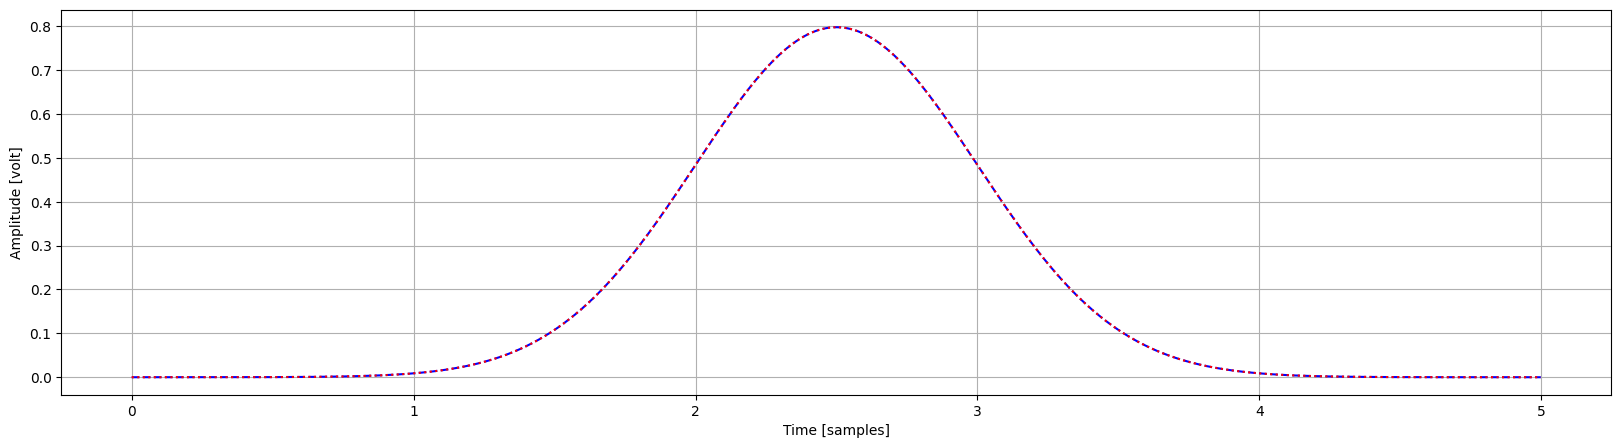

In [ ]:
TIMEsamples = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(fftsignal)))
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(time, np.abs(TIMEsamples), 'b--', time, y, 'r:')
ax.set_xlabel("Time [samples]")
ax.set_ylabel("Amplitude [volt]")
ax.grid(True)
plt.show()

In [ ]:

# time average spectra